# Diminishing Returns of Traditional 401k Investment

This notebook explores the optimal split between Traditional (Pre-Tax) and Roth contributions. Specifically, we investigate the point of diminishing returns for Traditional contributions where switching to Roth becomes more beneficial.


In [93]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

from app.analysis import run_full_simulation

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Baseline Parameters

We define a standard set of parameters for our simulation.


In [94]:
params = {
    "annual_income": 300000,
    "current_age": 35,
    "retirement_age": 65,
    "final_age": 90,
    "accumulation_return": 0.08,
    "retirement_return": 0.05,
    "contribution_input": 23000,  # Max out usually
    "use_max_contribution": True,
    "employer_match_percent": 0.0,
    "employer_match_limit": 0.0,
    "invest_tax_savings_percent": 1.0,
    "annual_raise_percent": 0.03,
    "retirement_income": 0.0,
    "inflation_rate": 0.025,
    "capital_gains_rate": 0.15,
    "current_401k_balance": 0.0,
    "current_roth_balance": 0.0
}


## Helper Function

A helper to run simulations across a range of Roth Splits (0% to 100%).


In [97]:
def analyze_splits(custom_params):
    splits = np.linspace(0, 1, 21)
    results = []

    for split in splits:
        p = custom_params.copy()
        p['roth_split_percent'] = split
        
        # Run only the split strategy part mostly, but simulation runs all 3.
        # We'll extract the 'split' result.
        sim_res = run_full_simulation(**p)
        dist = sim_res['distribution_split']
        
        # Metrics
        total_net_income = dist['Net_Income'].sum()
        avg_annual_net_income = dist['Net_Income'].mean()
        
        results.append({
            'Roth_Split_Percent': split,
            'Total_Net_Lifetime_Income': total_net_income,
            'Avg_Annual_Net_Income': avg_annual_net_income
        })
        
    return pd.DataFrame(results)


## Experiment 1: The "Sweet Spot" Curve
With baseline parameters (Income $100k, 0 starting balance), let's see optimal split.


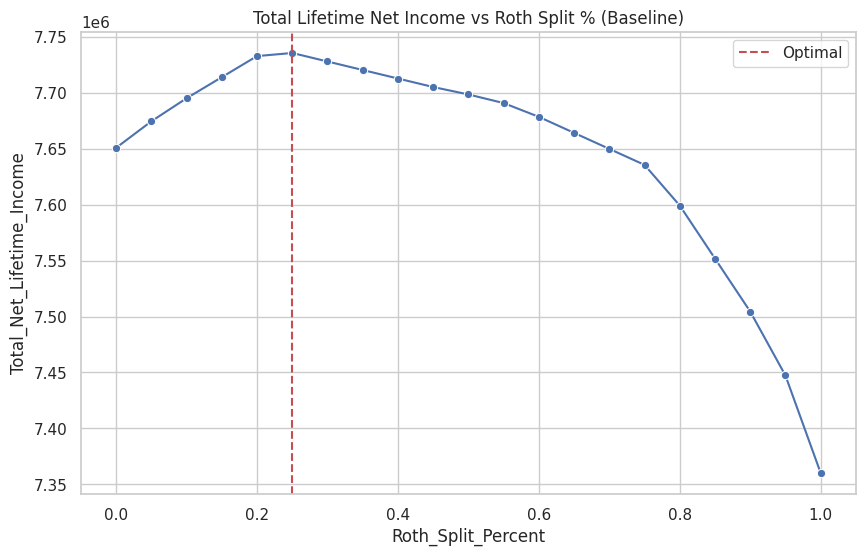

In [98]:
df_base = analyze_splits(params)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_base, x='Roth_Split_Percent', y='Total_Net_Lifetime_Income', marker='o')
plt.title('Total Lifetime Net Income vs Roth Split % (Baseline)')
plt.axvline(df_base.loc[df_base['Total_Net_Lifetime_Income'].idxmax()]['Roth_Split_Percent'], color='r', linestyle='--', label='Optimal')
plt.legend()
plt.show()


## Experiment 2: Effect of Starting Pre-Tax Balance
The user hypothesized that having a large Pre-Tax balance makes Roth more attractive (diminishing returns on Traditiona).
Let's test this by varying `current_401k_balance`.


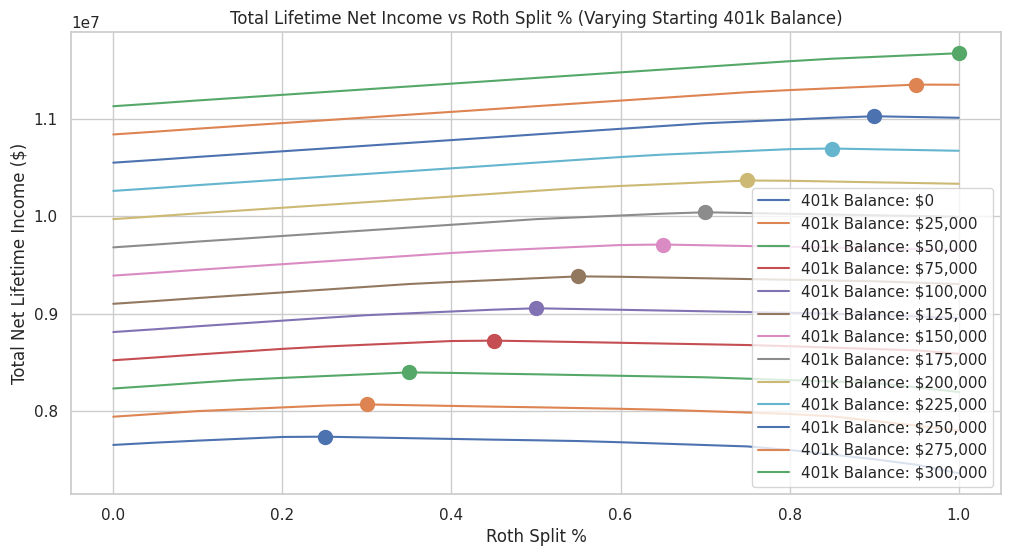

In [ ]:
balances = [i for i in range(0, 300001, 25000)]
results_by_balance = {}

for bal in balances:
    p = params.copy()
    p['current_401k_balance'] = bal
    results_by_balance[bal] = analyze_splits(p)

plt.figure(figsize=(12, 6))
ax = plt.gca()
for bal, df in results_by_balance.items():
    # Plot the line
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Total_Net_Lifetime_Income', label=f'401k Balance: ${bal:,}', ax=ax)

    # Find the maximum point for the current line
    max_income_row = df.loc[df['Total_Net_Lifetime_Income'].idxmax()]
    max_x = max_income_row['Roth_Split_Percent']
    max_y = max_income_row['Total_Net_Lifetime_Income']

    # Get the color of the most recently plotted line
    current_line_color = ax.lines[-1].get_color()

    # Plot a circle marker at the highest point with the same color
    ax.scatter(max_x, max_y, color=current_line_color, s=100, marker='o', zorder=5)

plt.title('Total Lifetime Net Income vs Roth Split % (Varying Starting 401k Balance)')
plt.xlabel('Roth Split %')
plt.ylabel('Total Net Lifetime Income ($)')
plt.legend()
plt.show()


## Experiment 3: Effect of Income Level
Higher income => higher marginal tax bracket => more benefit from Traditional (up to a point).
We normalize the results to compare the shape of the curves.


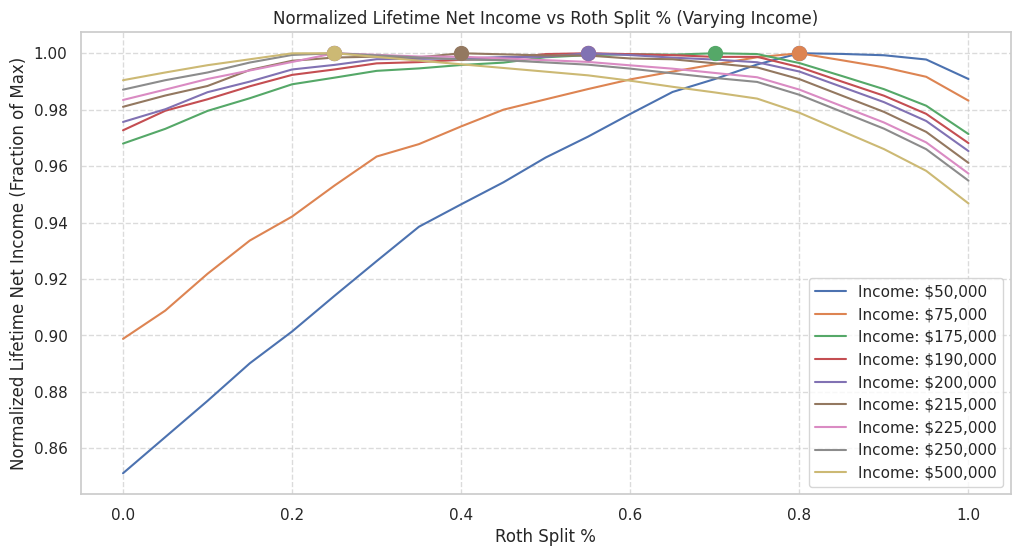


Optimal Roth Split Percentages:


,Income,Optimal Roth Split %,Max Normalized Income
0,50000,0.80,1.0
1,75000,0.80,1.0
2,175000,0.70,1.0
3,190000,0.55,1.0
4,200000,0.55,1.0
5,215000,0.40,1.0
6,225000,0.25,1.0
7,250000,0.25,1.0
8,500000,0.25,1.0


In [ ]:
incomes = [50000, 75000, 175000, 190000, 200000, 215000, 225000, 250000, 500000]
results_by_income = {}

for inc in incomes:
    p = params.copy()
    p['annual_income'] = inc
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_income[inc] = df

optimal_splits = []
plt.figure(figsize=(12, 6))
for inc, df in results_by_income.items():
    # Find the row with the maximum Normalized_Income
    max_income_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_split_percent = max_income_row['Roth_Split_Percent']
    max_normalized_income = max_income_row['Normalized_Income']

    # Plot the line
    line = sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Income: ${inc:,}')
    line_color = line.get_lines()[-1].get_color() # Get the color of the last plotted line

    # Plot the optimal point
    plt.scatter(optimal_split_percent, max_normalized_income, color=line_color, s=100, zorder=5)

    optimal_splits.append({
        'Income': inc,
        'Optimal Roth Split %': optimal_split_percent,
        'Max Normalized Income': max_normalized_income
    })

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Income)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print the table of optimal splits
print("\nOptimal Roth Split Percentages:")
optimal_df = pd.DataFrame(optimal_splits)
display(optimal_df)


## Experiment 4: Effect of Starting Age
Younger starting age means more years of compounding, which may affect the optimal split.
Results are normalized for comparison.


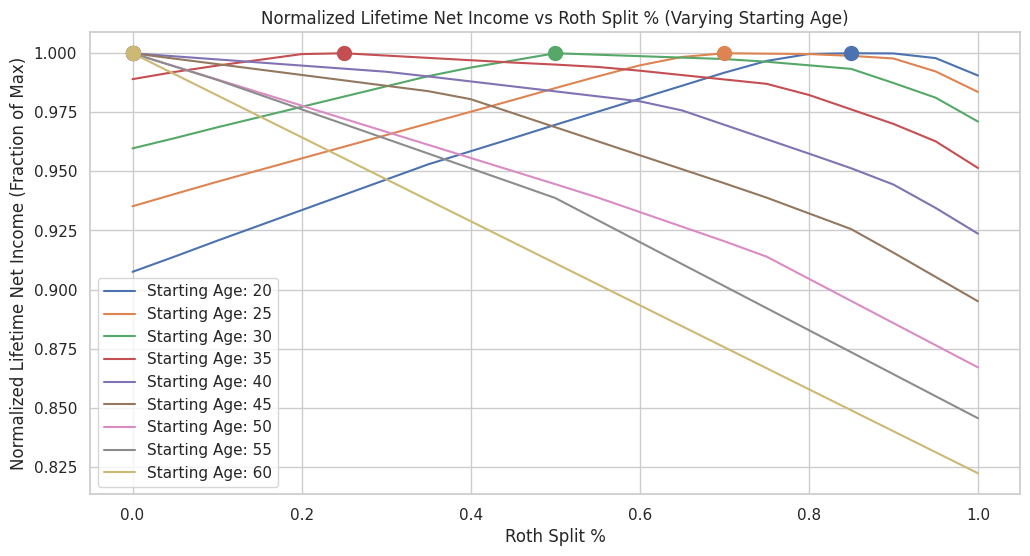


Optimal Roth Split Percentages:


,Starting Age,Optimal Roth Split %,Max Normalized Income
0,20,0.85,1.0
1,25,0.70,1.0
2,30,0.50,1.0
3,35,0.25,1.0
4,40,0.00,1.0
5,45,0.00,1.0
6,50,0.00,1.0
7,55,0.00,1.0
8,60,0.00,1.0


In [ ]:
ages = [20, 25, 30, 35, 40, 45, 50, 55, 60]
results_by_age = {}

for age in ages:
    p = params.copy()
    p['current_age'] = age
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_age[age] = df

optimal_results = []
plt.figure(figsize=(12, 6))
for age, df in results_by_age.items():
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Starting Age: {age}')
    
    # Get the color of the line that was just plotted
    line_color = plt.gca().lines[-1].get_color()
    
    # Find the point with the maximum Normalized_Income
    max_income_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_split = max_income_row['Roth_Split_Percent']
    max_income = max_income_row['Normalized_Income']
    
    # Highlight the optimal point with a circle of the same color
    plt.scatter(optimal_split, max_income, color=line_color, s=100, marker='o', zorder=5)

    optimal_results.append({
        'Starting Age': age,
        'Optimal Roth Split %': optimal_split,
        'Max Normalized Income': max_income
    })

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Starting Age)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.show()

optimal_df = pd.DataFrame(optimal_results)
print("\nOptimal Roth Split Percentages:")
display(optimal_df)


## Experiment 5: Effect of Employer Match
Employer match provides free money, which may affect the optimal split strategy.
Results are normalized for comparison.


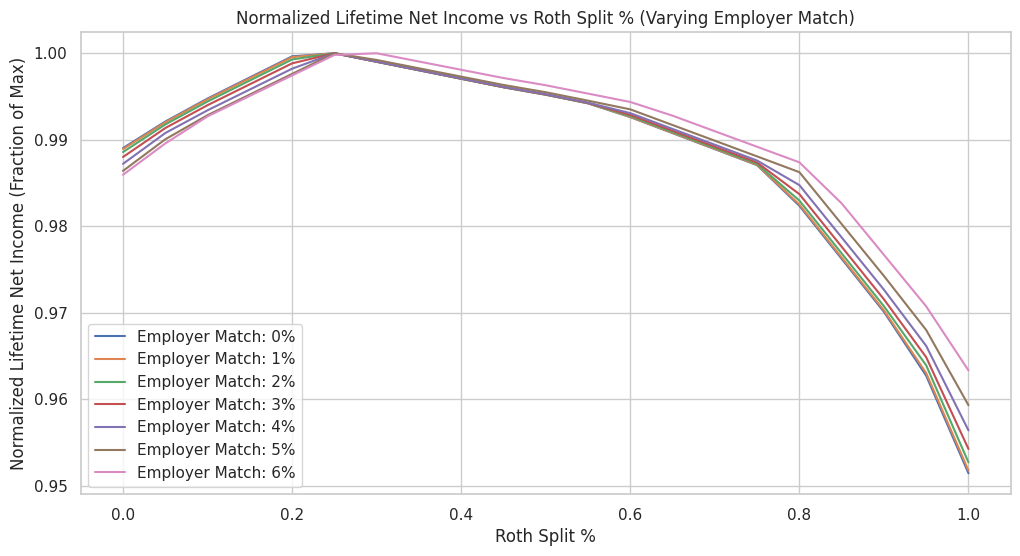

Employer_Match_Percent Optimal_Roth_Split_Percent  Max_Normalized_Income
                    0%                        25%                    1.0
                    1%                        25%                    1.0
                    2%                        25%                    1.0
                    3%                        25%                    1.0
                    4%                        25%                    1.0
                    5%                        25%                    1.0
                    6%                        30%                    1.0


In [ ]:
match_rates = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
results_by_match = {}

for match in match_rates:
    p = params.copy()
    p['employer_match_percent'] = match
    p['employer_match_limit'] = match  # Assuming 100% match up to the percentage
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_match[match] = df

plt.figure(figsize=(12, 6))
for match, df in results_by_match.items():
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Employer Match: {match*100:.0f}%')

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Employer Match)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.show()

optimal_splits = []
for match, df in results_by_match.items():
    optimal_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_splits.append({
        'Employer_Match_Percent': f'{match*100:.0f}%',
        'Optimal_Roth_Split_Percent': f'{optimal_row["Roth_Split_Percent"]*100:.0f}%',
        'Max_Normalized_Income': optimal_row['Normalized_Income']
    })

import pandas as pd
optimal_splits_df = pd.DataFrame(optimal_splits)
print(optimal_splits_df.to_string(index=False))
